In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/github/Online_Learning_Neural_Decoding

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/github/Online_Learning_Neural_Decoding


In [ ]:
# Seed Random Numbers with Numpy and the TensorFlow Backend

import math, time, os

import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.regularizers import l2
from keras.initializers import he_normal, he_uniform
from keras.layers import Input, Flatten, InputLayer, Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import BinaryAccuracy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

seed(1)
tf.random.set_seed(2)

# uncomment it if you are using the script version to import all packages/modules
# from neural_decoding.utils import
# from neural_decoding.data import NeuralData
# from neural_decoding.models import Batch_Model, Online_Model

In [ ]:
"""data.py"""

class NeuralData:
    def __init__(self, root_dir, subject, day, inj, task):
        """ load neural data 
        
        root_dir: str, path to the csv file (data and annotations)
        subject: list[tuple], list of tuples that each represents a dataset with a specific day and injection condition
        day: int, the number of bins you want to use together to predict y
        inj: int, the 
        task: int, the behavior variable that we want to predict
        """
        self.datasetName = os.path.join(root_dir, 'TRACES_'+ subject +'_'+ day +'_' + inj + '.csv')
        self.labelName = os.path.join(root_dir, 'BEHAVIOR_'+ subject +'_'+ day +'_' + inj + '.csv')
        # (number of features/neurons, number of samples)
        self.X = np.transpose(np.loadtxt(self.datasetName, delimiter=',')) 

        # filling missing values in the csv
        self.X[:, 0] = self.X.mean(axis=1) 

        # convert label type from float to int
        self.y = np.loadtxt(self.labelName, delimiter=',')[:, task]
        encoder = LabelEncoder()
        encoder.fit(self.y)
        self.y = encoder.transform(self.y) 

    
    def __str__(self):
        return f"<datasetName = {self.datasetName}, labelName = {self.labelName}, X = {self.X.shape}, y = {self.y.shape}>"
    

    def get_stats(self):
        return sum(self.y) / len(self.y)


    def preprocess(self, win_size, time_series=True):
        """ preprocess data into real-time neural decoding task

        win_size: previous time steps for input we want to consider for predicting each data point
        time_series: whether the data will be converted into a time-series
        """

        X, y = [], []

        # for recurrent models,
        for i in range(self.X.shape[0] - win_size): # 0 ~ 2989
            X.append(self.X[i:(i + win_size), :]) # v = [10, 273] # 0:10 = frame 1 ~ 10
            y.append(self.y[i + win_size]) # predict frame 11 ~ frame 3000 

        # Xs = [2990, window_size, 273] / ys = [2990, 1]
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)

        if time_series == False:
            X = X.reshape(X.shape[0], -1) # Xs = [2990, 2730]

        return {'input': X, 'label': y}

if __name__ == '__main__':
    set1 = NeuralData('data', '1004', '1', '4', 2)
    pset1 = set1.preprocess(50, True)
    print(pset1['input'].shape, pset1['label'].shape)

(2950, 50, 273) (2950, 1)


In [ ]:
"""models.py"""

class Model:
    def __init__(self, model, time_steps, num_features, units, lr_rate, drop_rate, opt):
        """define a Keras model
        
        model: model you want to build
        time_steps: number of steps in time-series data
        num_features: number of features in time-series data
        units: number of neurons in each layer
        lr_rate: learning rate for the optimizer
        drop_rate: dropout rate
        opt: function for the optimizer 
        """

        # inputs = Input(shape=(time_steps, num_features))
        self.timer = []
        self.acc = []

        self.model = Sequential()
        if model is 'gru':
            self.model.add(GRU(units, unroll=True, input_shape=(time_steps, num_features)))
        elif model is 'lstm':
            self.model.add(LSTM(units, unroll=True, input_shape=(time_steps, num_features)))
        self.model.add(Dropout(drop_rate)) # to regularize the dense layer
        self.model.add(Dense(1, activation='sigmoid'))

        if opt is 'adam':
            self.model.compile(optimizer=Adam(learning_rate=lr_rate), loss='binary_crossentropy', metrics = ['binary_accuracy'])
        if opt is 'sgd':
            self.model.compile(optimizer=SGD(learning_rate=lr_rate, nesterov=True), loss='binary_crossentropy', metrics = ['binary_accuracy'])


    def __str__(self):
        return f"<timer = {self.timer}, acc = {self.acc}, model = {self.model}>"


    def run(self):
        """ abstract method
        """
        pass


    def train(self, train_datasets, params, is_freeze):
        """pretrain model on different datasets

        train_datasets:
        params:
        is_freeze:
        """

        # stack datasets to build a new training set
        train_x = train_datasets[0]['input']
        train_y = train_datasets[0]['label']

        for i in range(len(train_datasets)-1):
            train_x = np.vstack((train_x, train_datasets[i+1]['input']))
            train_y = np.vstack((train_y, train_datasets[i+1]['label']))

        self.model.fit(train_x, train_y, epochs=params['epochs'], batch_size=params['batch'], verbose=0)

        # freeze all layers, but the last layer for fine-tuning
        if is_freeze:
            for layer in self.model.layers[:-1]:
                layer.trainable = False


class Online_Model(Model):
    def __init__(self, model, time_steps, num_features, units, lr_rate, drop_rate, opt):
        super().__init__(model, time_steps, num_features, units, lr_rate, drop_rate, opt)


    def run(self, params, train_datasets, test_datasets, is_freeze):
        # build models for the baseline and our method 
        
        super().train(train_datasets, params, is_freeze)

        # transfer online learning on a stream of datasets
        for idx, dataset in enumerate(test_datasets):            
            y_true = dataset['label']

            # calculate number of blocks(updates) for 50% of test set
            block_num = math.ceil(dataset['input'].shape[0] / params['p'])

            # for each block, make predictions and then update the model with the p frames in a block(update_time)
            start_time = time.time()
            for j in range(block_num):
                # make predictions and update on inputs
                if j == block_num-1:
                    # total num of data samples might make the last block not divisible by params['p']
                    y_pred_block = self.model.predict(dataset['input'][j*params['p']:])
                    y_pred_block = (y_pred_block > 0.5).astype('int32')

                    # online learning: update right away data block
                    self.model.fit(dataset['input'][j*params['p']:], dataset['label'][j*params['p']:], epochs=params['update_epoch'], verbose=0, batch_size=params['p'])
                else:
                    y_pred_block = self.model.predict(dataset['input'][j*params['p']:(j+1)*params['p']])
                    y_pred_block = (y_pred_block > 0.5).astype('int32')

                    # online learning: update right away data block
                    self.model.fit(dataset['input'][j*params['p']:(j+1)*params['p']], dataset['label'][j*params['p']:(j+1)*params['p']], epochs=params['update_epoch'], verbose=0, batch_size=params['p'])

                # append predictions for each block for evaluation in the end
                if j == 0: 
                    y_pred = y_pred_block
                else:
                    y_pred = np.append(y_pred, y_pred_block)
                
            # calculate prediction time per sample
            end_time = time.time()    
            dataset_time = (end_time - start_time) / dataset['input'].shape[0]

            # calculate metrics for performance evaluation
            self.timer.append(dataset_time)
            self.acc.append(accuracy_score(y_true, y_pred))
            

class Batch_Model(Model):
    def __init__(self, model, time_steps, num_features, units, lr_rate, drop_rate, opt):
        super().__init__(model, time_steps, num_features, units, lr_rate, drop_rate, opt)


    def run(self, params, train_datasets, test_datasets, is_freeze):
        """batch train and evaluate the model

        params:
        train_datasets:
        test_datasets:
        is_transfer:
        """
        
        super().train(train_datasets, params, is_freeze)

        # make predictions on a stream of test datasets and fine-tune models on the training set
        for idx, dataset in enumerate(test_datasets):
            y_true = dataset['label']

            # make predictions on the current set of features
            start_time = time.time()
            y_pred = self.model.predict(dataset['input'])
            y_pred = (y_pred > 0.5).astype('int32')
            end_time = time.time()
            dataset_time = (end_time - start_time) / dataset['input'].shape[0]

            # calculate metrics for performance evaluation
            self.timer.append(dataset_time)
            self.acc.append(accuracy_score(y_true, y_pred))


if __name__ == '__main__':
    a = Batch_Model(model='lstm', time_steps=10, num_features=273, units=30, lr_rate=0.01, drop_rate=0.25, opt='adam')
    b = Online_Model(model='lstm', time_steps=10, num_features=273, units=30, lr_rate=0.01, drop_rate=0.25, opt='adam')

In [ ]:
"""utils.py"""

def plot_dist(inp, max_value):
    """visualize the distribution of input features
    
    input:
    max_value:
    """
    fig = plt.figure(figsize = (20,10))
    n_idx = np.arange(inp.shape[1])

    # normalize values to max_value to make it b/w 0 and 1
    n_value = inp.mean(axis=0) / max_value

    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("neuron id")
    ax.set_ylabel("avg neuron value") 
    ax.bar(n_idx, n_value, align='center', alpha=0.5)
    fig.show()

def plot_performance(batch_perform, online_perform):
    """visualize ground truth and predicted neurons' fine movements
    
    batch_perform: list, batch metric per dataset
    online_perform: list, online metric per dataset
    """

    # plt.figure(figsize=(15,10))
    x = np.arange(len(batch_perform)) + 1
    plt.plot(x, batch_perform, 'r', linestyle='-', label='batch')
    plt.plot(x, online_perform, 'b', linestyle='-', label='online')
    plt.xlabel('dataset')
    plt.ylabel('accuracy')
    plt.title('[test accuracy] online vs. batch')
    plt.legend()
    plt.show()

<datasetName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/TRACES_1004_3_1.csv, labelName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/BEHAVIOR_1004_3_1.csv, X = (3000, 273), y = (3000,)>
<datasetName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/TRACES_1004_3_2.csv, labelName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/BEHAVIOR_1004_3_2.csv, X = (3000, 273), y = (3000,)>
<datasetName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/TRACES_1004_4_1.csv, labelName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/BEHAVIOR_1004_4_1.csv, X = (3000, 273), y = (3000,)>
<datasetName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/TRACES_1004_4_2.csv, labelName = /content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data/BEHAVIOR_1004_4_2.csv, X = (3000, 273), y = (3000,)>
<datasetName = /content/drive/MyDrive/github/Online_Learning

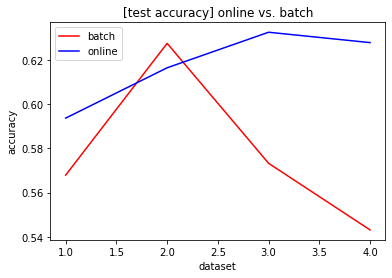

In [ ]:
# select datasets used for training and testing
subject = '1004'
train_datasets_info = [('3','1'), ('3','2')]
test_datasets_info = [('4','1'), ('4','2'), ('4','3'), ('5','3')]

task = 2
time_step = 10
path = '/content/drive/MyDrive/github/Online_Learning_Neural_Decoding/data'

h_params = [{'n_layers':2, 'units':10, 'lr':1e-4, 'drop_rate':0.1, 'opt':'adam', 'w_decay':0.05, 'epochs':20, 'batch':32, 'p':5, 'update_epoch':1}]


# list of dicts
train_datasets = []
test_datasets = []

# load dataset and preprocess according to the model you want to use
for day, inj in train_datasets_info:
    train_data = NeuralData(path, subject, day, inj, task)
    print(train_data)
    dataset = train_data.preprocess(time_step, True)
    train_datasets.append(dataset)

for day, inj in test_datasets_info:
    test_data = NeuralData(path, subject, day, inj, task) 
    print(test_data)
    dataset = test_data.preprocess(time_step, True)
    test_datasets.append(dataset)

print(len(train_datasets))
print(len(test_datasets))

for params in h_params:
    batch_model = Batch_Model(model='lstm', time_steps=time_step, num_features = train_datasets[0]['input'].shape[-1], units=params['units'], lr_rate=params['lr'], drop_rate=params['drop_rate'], opt=params['opt'])
    online_model = Online_Model(model='lstm', time_steps=time_step, num_features = train_datasets[0]['input'].shape[-1], units=params['units'], lr_rate=params['lr'], drop_rate=params['drop_rate'], opt=params['opt'])
    
    batch_model.run(params, train_datasets, test_datasets, False)
    online_model.run(params, train_datasets, test_datasets, False)
    
    plot_performance(batch_model.acc, online_model.acc)